# Ephemeris object cube imaging (mosaic)

## Comet Giacobini-Zinner  -- external JPL-Horizons table (use all the data set)

Requires CAS-14152 fix

For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. The following demo is one of the stadard procudures for processing of such data.


The following steps describes that imaging with updated ephemeris table which is different from one used to track the source during observation. In that case the source image will be centered using the updated eph table while the original internal eph table will be used for re-phasing during gridding.

In [1]:
# extra packages needed
#import os
#!pip install astropy
#!pip install aplpy

In [2]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
# requires ipynb 
from ipynb.fs.defs.ALMAephemimagingCometGZCubesrcMosaicTrackfield import *

In [3]:
from casatasks import getephemtable, tclean, exportfits, listobs, imstat, imhead
from casatools import measures, quanta, table, image
import os
from astropy.io import fits
from matplotlib import pylab as pl
import numpy as np
import aplpy
me = measures()
qa = quanta()
tb = table()
ia = image()

## Imaging with external epehemeris table

In [4]:
datapath='/home/casa/data/casatestdata-large/stakeholder/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/stakeholder/alma/'

In [5]:
msfile=[datapath+'2017.1.00750.T_tclean_exe1.ms',datapath+'2017.1.00750.T_tclean_exe2.ms']

In [6]:
# Find obs time range from MSes
# for generating ephemeris table, add extra time at the end
# time interval of the attached ephem table is 1 min.
timerangestr=[]
for vis in msfile:
    ret=listobs(vis)
    calbegintime = qa.time(qa.quantity(ret['BeginTime'],'d'),form='ymd')[0]
    calendtime = qa.time(qa.quantity(ret['EndTime'],'d'),form='ymd')[0]
    # add extra time (2min) at the end to ensure the interpolation for determine the position works
    calendmodtime = qa.time(qa.quantity(ret['EndTime']+0.000694444*2.,'d'),form='ymd')[0]
    bt = ret['BeginTime']
    print(f'mdj start: {bt}')
    print (f'observation time range : {calbegintime}~{calendtime}')
    timerangestr.append(f'{calbegintime}~{calendmodtime}')
    
print(timerangestr)

mdj start: 58377.42770666667
observation time range : 2018/09/16/10:15:54~2018/09/16/11:03:42
mdj start: 58383.51988666667
observation time range : 2018/09/22/12:28:38~2018/09/22/13:16:21
['2018/09/16/10:15:54~2018/09/16/11:05:42', '2018/09/22/12:28:38~2018/09/22/13:18:21']


In [7]:
# generate JPL-Horizons ephem table
intimerange = timerangestr[0].split('~')[0]+'~'+timerangestr[1].split('~')[1]
getephemtable(objectname='90000322', asis=True, timerange=intimerange, 
              interval='1m', outfile='21PG-Z_JPL-Horizons_20180916_0922.tab', 
              rawdatafile='myraw.dat',overwrite=True)

2024-04-26 22:00:10	WARN	getephemtable::::casa	21PG-Z_JPL-Horizons_20180916_0922.tab exists, will be overwritten
2024-04-26 22:00:10	WARN	getephemtable::::casa	myraw.dat exists, will be overwritten


In [8]:
imgname='21PGZComet-cubesrc-mosaic-exteph'

In [9]:
delete_tcleanimages(imgname)

In [10]:
inphasecenter='21PG-Z_JPL-Horizons_20180916_0922.tab'

In [11]:
#os.system(f'cp -r {datapath}{msfile} {msfile}')

In [12]:
ret=tclean(vis=msfile, field='21PGiacobini-Zinner', spw=['0','0'], \
            antenna=['0,1,2,3,4,5,6,7,8,9,10,11', '0,1,2,3,4,5,6,7,8,9'], \
            scan=['7,11,15,19,23', '8,12,16,20,24'], \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=imgname, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter=inphasecenter, stokes='I', specmode='cubesource', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, \
            gridder='mosaic', mosweight=False, \
            usepointing=True, pblimit=0.2, deconvolver='hogbom', \
            restoration=True, restoringbeam='common', pbcor=True, \
            #weighting='briggsbwtaper', robust=0.5, npixels=0, niter=30000, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.274Jy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0, fastnoise=False, restart=True, \
            calcres=True, calcpsf=True, savemodel='none', \
            parallel=False, verbose=True)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%
2024-04-26 22:01:00	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.252404123544693 at index [76, 56, 0, 757])

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


135

Convert a CASA image to FITS image for displaying the image via aplpy

In [13]:
imstatres = imstat(imgname+'.image')
maxchan = imstatres['maxpos'][3]
print(maxchan)

489


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Figure size 2000x1000 with 0 Axes>

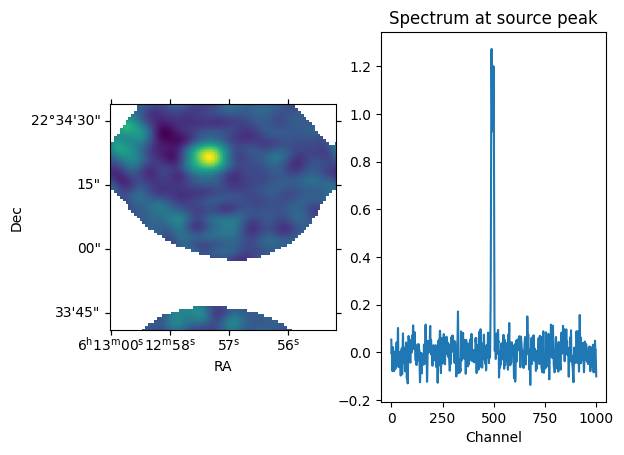

In [14]:
dispImage(f'{imgname}.image',chanslice=maxchan, useAstropy=True)

In [15]:
printImageCenter(imgname+'.image')

('06:12:57.071', '+022.34.07.834')

In [16]:
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
obsdate=iminfo['date-obs']

In [17]:
intab=get_attachedEphemtablepath(msfile[0], '21PGiacobini-Zinner')
intabdir = ephem_dir(intab,iminfo['date-obs'],'ALMA')
exttabdir = ephem_dir('21PG-Z_JPL-Horizons_20180916_ms0.tab',iminfo['date-obs'],'ALMA')
print("internal ephem dir = ",qa.time(intabdir['m0'],prec=9),qa.angle(intabdir['m1'],prec=9))
print("external ephem dir = ",qa.time(exttabdir['m0'],prec=9),qa.angle(exttabdir['m1'],prec=9))

internal ephem dir =  ['06:12:57.770'] ['+022.34.20.236']
external ephem dir =  ['06:12:57.071'] ['+022.34.07.834']


Determine image channel frequency at the peak 

In [18]:
ia.open('tst-cubesrc-trackfield.image')
csys = ia.coordsys()
csysrec = csys.torecord()
ia.done()
restfreq = csysrec['spectral2']['restfreq']
print('restfreq:',restfreq)

restfreq: 354505473000.0


In [19]:
specaxis=csys.findcoordinate('spectral')['pixel'][0]

In [20]:
pixel=csys.referencepixel()
print(pixel)

{'ar_type': 'absolute', 'numeric': array([40., 40.,  0.,  0.]), 'pw_type': 'pixel'}


In [21]:
pixel['numeric'][specaxis] = 489
f_peak = csys.toworld(pixel)['numeric'][3]
# this is different from what I read from the Viewer
print(f_peak,'Hz')

354504979266.61194 Hz


In [22]:
#print(casadatetoastropydate(obsdate))

In [23]:
from casatools import measures
ephemtab = get_attachedEphemtablepath(msfile[0], '21PGiacobini-Zinner')
_me = measures()
_me.framecomet(ephemtab)
_me.doframe(_me.observatory('ALMA'))
_me.doframe(_me.epoch('utc',obsdate))
cometpos = _me.measure(_me.direction('COMET'),'ICRS')
print(cometpos)

{'m0': {'unit': 'rad', 'value': 1.6273353091131537}, 'm1': {'unit': 'rad', 'value': 0.39388505484928327}, 'refer': 'ICRS', 'type': 'direction'}


In [24]:
mjd0=qa.quantity(obsdate,'d')['value']
print(mjd0)

58377.427764999986


In [25]:
tb.open(ephemtab)
mjdcol = tb.getcol('MJD')
#indx = np.abs(mjdcol - mjd0).argmin()
#radvel = tb.getcell('RadVel',indx)
radc = tb.getcol('RA')
decdc = tb.getcol('DEC')
rhoc = tb.getcol('Rho')
radvel=tb.getcol('RadVel')
tb.done()

True

In [26]:
radv = np.interp(mjd0,mjdcol,radvel)
qradv = qa.convert(qa.quantity(radv,'AU/d'),'km/s')
raval = np.interp(mjd0,mjdcol,radc)
decval= np.interp(mjd0,mjdcol,decdc)
rhoval = np.interp(mjd0,mjdcol,rhoc)
print(qradv)
print(raval,decval)

{'unit': 'km/s', 'value': 3.35206559623668}
93.24003966532386 22.57365939602003


In [27]:
# following frequencies are measured on the viewer 
# imaging with TOPO
ftopo = 354.50107*10**9
# imaging with LSRK
flsrk = 354.48068*10**9
vrad = qradv['value']
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch(str(mjd0)+'d'))
v = me.radialvelocity('GEO',str(-1*vrad)+'km/s')
dop=me.todoppler('radio',v)
print(f'vel={v}')
print(f'dop={dop}')
#mfrq = me.frequency('LSRK', qa.quantity(flsrk,'Hz'))
mfrq = me.frequency('TOPO', qa.quantity(ftopo,'Hz'))
print(mfrq)
print('expected frequecy at the peak in rest(source) frame:',me.tofrequency('rest', dop, mfrq))
print(f'compared to freq_peak from the image = {f_peak} Hz')

vel={'m0': {'unit': 'm/s', 'value': -3352.06559623668}, 'refer': 'GEO', 'type': 'radialvelocity'}
dop={'m0': {'unit': 'm/s', 'value': -3352.084336653307}, 'refer': 'RADIO', 'type': 'doppler'}
{'m0': {'unit': 'Hz', 'value': 354501070000.0}, 'refer': 'TOPO', 'type': 'frequency'}
expected frequecy at the peak in rest(source) frame: {'m0': {'unit': 'Hz', 'value': 354505033800.4638}, 'refer': 'REST', 'type': 'frequency'}
compared to freq_peak from the image = 354504979266.61194 Hz


In [28]:
print('diff = ',354505033800.4638-354504979266.61194)
print('chan width : ',0.1221004*10**6)

diff =  54533.85186767578
chan width :  122100.4
